# From Keras to tf.keras and tf to tf 2.0: The Journey

Keras could be seen as a what we call the `Wrapper` of either `tensorflow`, `theano` or `CNTK` before the release of `tensorflow 2.0` but it's definition has changed since the rlease of `tf 2.0`. Keras was not in active development for quite some time and was not compatible with `python > 3.5` but a week ago or so, they have released a new version which is now compatible with `python >= 3.6`. 

# The Change:

`Tensorflow 2.0` is IMO, a complete shift as a lots of things have changed. I'd say that it has been for better specially for those who wanted to be somewhere between high level Keras for faster developments and  tensorflow for research and very high customization as `tf 2.0` provides both. So it won't be completly wrong to say that tf 2.0 and Keras are almost same today. We'll be looking at the aspect of building a custom Model and Layer using the tf 2.0 and Keras.

Aprt from that tensorflow has allowed the **Eager Execution** where you can see the results right away instad of building a static graph so that was an exclusiveness `PyTorch` **USED** to have. So it has become Build **and** run (how python works) instead of build **then** run (how c/c++ works).

## Layers
Before we start, we need to note some important facts about layers:

1. Each layer uses the `tf.keras.layers.Layer` as a parent class.

2. There are weights associated with layers. These weights can be trainable or non-trainable according to your requirement.

3. Every layer is initialized with initial weights and it can be any of the `tf.keras.initializers` such as `zeros`, `normal`, `ones` and the most widely used `glorot_uniform`.

4. Layers can be recursively combined (inside one another). So the outer layer will depend on the weights of the inner layer.

5. We need to have the understanding of the shape of Input coming to the layer and number of output neurons it'll give as an output. We usually do no know the shape so we use a method `build` to get the shape while forward pass.

6. A layer may or not have the `loss function` or the `Regularization`. If there are any transformations  implemented in the layers, these have to be executed inside the `call`  (for forward pass) method.

7. There are few methods that we can choose to apply. `__init__`  and `call` is a must and using the `build` method before initializing the weights is the best practice to follow in dynamic environments. `grt_config` and `from_config` are used if we want to serialize our layers (for saving).

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import Model
from tensorflow.keras.activations import relu,sigmoid, softmax, tanh
from tensorflow.keras.initializers import glorot_normal



from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Custom Layers

In [2]:
class CustomDense(Layer):
    '''
    Build custom layer mimicks the Dense Layer
    '''
    def __init__(self,units=128,initializer='glorot_uniform',activation=None,name=None,**kwargs):
        '''
        Constructor of the class
        args:
            units: {int} number of neurons in the layer
            initializer: {string or callable instance of tf.keras.initializers } initial weights
            activation: {callable instance of tf.keras.activations} activation function to use
            name: name of the layer {string}. There is already a name param in Base Class
            kwargs: keyword arguments of the base Layer Class
        '''
        super(CustomDense,self).__init__(**kwargs) # constructor of Base Layer class
        self.units = units # number of neurons
        self.activation = activation # activation function
        self.initializer = initializer # initializer
        if name: # it works but but you SHOUD NOT USE IT
            self._name = name
        
    def build(self,input_shape):
        '''
        method typically used to create the weights of Layer subclasses. During forward pass or call() model
        will automatically call the build method to get the shape of the input tensor
        args:
            input_shape: a tensor describing shape of input. it'll be passed automatically as input.shape
        '''
        self.w = self.add_weight(shape=(input_shape[-1],self.units),initializer=self.initializer,trainable=True)
        # add_weight is a method of Layer base class. input_shape[-1] gives number of features
        
        self.b = self.add_weight(shape=(self.units,),initializer=self.initializer,trainable=True)
        # add bias and set to trainable. NOTE: never forget to add a , after self.units as
        # (1) == int(1) but (1,) = tuple([1])

        
    def call(self,input_tensor):
        '''
        method to implement the forward pass
        args:
            input: input tensor
        '''
        result = tf.matmul(input_tensor,self.w)+self.b 
        # apply the formula y = wx + b in matric multiplication form
        
        if self.activation:
            result = self.activation(result) # apply activation function
            
        return result

In [3]:
layer = CustomDense(8,activation=softmax,name='my_layer')

# below code is to just create random tensor which will work as the input to the Layer
ini = tf.random_uniform_initializer()
tensor = ini((4,3)) # 4 data points with 3 attributes
tensor

<tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[-0.02950236, -0.00495137, -0.00252123],
       [ 0.01312666, -0.02502874, -0.02675922],
       [-0.03385033, -0.00761297, -0.02917661],
       [ 0.03630997,  0.02617916,  0.03764183]], dtype=float32)>

In [4]:
print(layer(tensor)[0].numpy().sum())  
# to check if our model is outputting correct sigmoid as sum==1 for each row
layer(tensor)

0.99999994


<tf.Tensor: shape=(4, 8), dtype=float32, numpy=
array([[0.18900216, 0.12751332, 0.11943944, 0.20081049, 0.08404858,
        0.0863165 , 0.09276157, 0.10010795],
       [0.19242592, 0.12541182, 0.12281655, 0.19617727, 0.08546472,
        0.08314477, 0.09559486, 0.09896398],
       [0.18809876, 0.12761146, 0.11893441, 0.20296454, 0.08299486,
        0.08540022, 0.0938602 , 0.10013554],
       [0.19753608, 0.12389737, 0.12073223, 0.1900218 , 0.08861208,
        0.08450832, 0.0930167 , 0.10167544]], dtype=float32)>

In [5]:
layer.weights # weights and biases. we can access layer.b, layer.w individually too

[<tf.Variable 'my_layer/Variable:0' shape=(3, 8) dtype=float32, numpy=
 array([[ 0.56216127, -0.39661252,  0.42390555, -0.669488  ,  0.6075563 ,
         -0.592629  ,  0.4019621 ,  0.00183886],
        [ 0.20696324, -0.07819968, -0.69159585,  0.09262097, -0.00578594,
         -0.00544608, -0.0497759 ,  0.6573182 ],
        [ 0.17576718,  0.15202194,  0.267255  , -0.19194454,  0.48316234,
          0.6059707 , -0.39392868,  0.03210783]], dtype=float32)>,
 <tf.Variable 'my_layer/Variable:0' shape=(8,) dtype=float32, numpy=
 array([ 0.3222744 , -0.10102111, -0.14497197,  0.34504777, -0.4870283 ,
        -0.4954994 , -0.3968854 , -0.32789817], dtype=float32)>]

In [6]:
layer.name  # layer._name works too. Not a Private variable as there are no private variables in Python

'my_layer'

## Privilaged argument in the `Call()`
There is a special argument  `training`  given for the call method. You can use the Boolean {True, False} for this option to use in Custom Layer to tell if the layer is working with Training or inference (results). For example, there are some methods where you can train differently and when you have to predict, a different strategy is used. For example you can dropout in the training.

In [7]:
class HypotheticalLayer(Layer):
    '''
    Build a random layer
    '''
    def __init__(self,units=4,initializer='glorot_uniform',drop_rate=0.23,**kwargs):
        super(HypotheticalLayer,self).__init__(**kwargs) # constructor of Base Layer class
        self.units = units # number of neurons
        self.initializer = initializer # initializer
        self.drop_rate = drop_rate
        
        
    def build(self,input_shape):
        
        self.w = self.add_weight(shape=(input_shape[-1],self.units),initializer=self.initializer,trainable=True)
        
        self.b = self.add_weight(shape=(self.units,),initializer=self.initializer,trainable=True)
   
        
    def call(self,input_tensor,training=False):
        '''
        method to implement the forward pass with training parm
        args:
            input: input tensor
            training: {bool} whether the layer is in training phase or not
        '''
        result = tf.matmul(input_tensor,self.w)+self.b 
        
        if training:
            result = tf.nn.dropout(result,rate=self.drop_rate) # apply dropout
            
        return result

In [8]:
hypo_layer = HypotheticalLayer(drop_rate=0.33)
hypo_layer(tensor,training=True) # uses the call method. Apply dropout randomly to 33%

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 0.5403205 ,  1.2124445 , -0.0805456 ,  0.8686729 ],
       [ 0.58374757,  1.1929944 , -0.02930541,  0.90038687],
       [ 0.558274  ,  0.        , -0.        ,  0.        ],
       [ 0.        ,  1.2389462 , -0.06333673,  0.        ]],
      dtype=float32)>

In [9]:
hypo_layer(tensor) # default training=False

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 0.36201477,  0.8123379 , -0.05396555,  0.58201087],
       [ 0.39111087,  0.7993062 , -0.01963463,  0.6032592 ],
       [ 0.37404358,  0.805547  , -0.04686815,  0.5788237 ],
       [ 0.36929113,  0.830094  , -0.04243561,  0.5756116 ]],
      dtype=float32)>

## Nested Layers
We'll try to build a layer composed of multiple `CustomDense` layers with activation associated with each. 
Just for the demonstration purpose, we'll cover multiple scenario of how can we initialise our `CustomLayer`

In [10]:
class NestedDense(Layer):
    '''
    Build nested layer made of multiple CustomDense layer
    '''
    def __init__(self,l1_unit=8,l2_unit=8,l2_units=4,**kwargs):
        '''
        Constructor of the class
        args:
            l1_units, l2_units, l3_units = no of neurons in the 3 sub layers
            kwargs: keyword arguments of the base Layer Class
        '''
        super(NestedDense,self).__init__(**kwargs) # constructor of Base Layer class
        
        self.l1 = CustomDense(l1_unit,initializer=glorot_normal) # no activation, callable initializer
        self.l2 = CustomDense(l2_units,initializer='ones',activation=relu) 
        # relu activation, he_uniform initializer
        self.l3 = CustomDense(l1_unit) # no activation. default initializer

        
    def call(self,input_tensor):
        '''
        method to implement the forward pass
        args:
            input: input tensor
        '''
        x = self.l1(input_tensor) # layer 1 
        x = tanh(x) # as we had no activation function in layer 1
        
        x = self.l2(x) # pass to layer 2. we have a default activation as relu
        
        x = self.l3(x) # for our hypothetical work, we do not need any activation for output
            
        return x

In [11]:
nested_dense = NestedDense()
nested_dense(tensor)

<tf.Tensor: shape=(4, 8), dtype=float32, numpy=
array([[ 2.5076945e+00, -7.9610229e-01,  8.6938989e-01,  1.4206990e+00,
        -2.1850250e+00,  1.9344091e-03,  1.9144945e+00, -1.1088862e+00],
       [ 2.6646819e+00, -8.2978290e-01,  9.2027736e-01,  1.5047566e+00,
        -2.3183215e+00, -1.7661750e-02,  2.0594294e+00, -1.1892037e+00],
       [ 2.5011158e+00, -7.9469085e-01,  8.6725748e-01,  1.4171766e+00,
        -2.1794391e+00,  2.7555823e-03,  1.9084210e+00, -1.1055205e+00],
       [ 2.6480989e+00, -8.2622510e-01,  9.1490197e-01,  1.4958774e+00,
        -2.3042409e+00, -1.5591741e-02,  2.0441196e+00, -1.1807194e+00]],
      dtype=float32)>

In [12]:
nested_dense.weights # layer has weights of all the layers

[<tf.Variable 'nested_dense/custom_dense_1/Variable:0' shape=(3, 8) dtype=float32, numpy=
 array([[ 0.21393721,  0.70684   ,  0.6212779 ,  0.20657147,  0.2349035 ,
          0.4939701 ,  0.59531415, -0.95688975],
        [ 0.02069471,  0.11810245, -0.5300749 , -0.4921239 , -0.3508117 ,
         -0.03057094, -0.40324438,  0.5845389 ],
        [ 0.8529533 , -0.25923324,  0.7479166 , -0.06946068, -0.942283  ,
          0.05722449, -0.23094518,  0.06954481]], dtype=float32)>,
 <tf.Variable 'nested_dense/custom_dense_1/Variable:0' shape=(8,) dtype=float32, numpy=
 array([ 0.5866819 ,  0.07573399,  0.49254066, -0.26131037,  0.27363467,
         0.05302572,  0.26541996, -0.49118564], dtype=float32)>,
 <tf.Variable 'nested_dense/custom_dense_2/Variable:0' shape=(8, 4) dtype=float32, numpy=
 array([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]

## Serialising Layers
When we want to save the layer and use later, we need to use the `get_config()` from the **Parent** or Super Class. `get_config()` needs some configuration such as number of units or other parameters.

In [13]:
class SerializableLayer(Layer):
    '''
    Build custom layer mimicks the Dense Layer which can noe be serialised or saved
    '''
    def __init__(self,units=128,initializer='glorot_uniform',activation=None,**kwargs):
        super(SerializableLayer,self).__init__(**kwargs) 
        self.units = units
        self.activation = activation 
        self.initializer = initializer 
        
    def build(self,input_shape):
        
        self.w = self.add_weight(shape=(input_shape[-1],self.units),initializer=self.initializer,trainable=True)
       
        self.b = self.add_weight(shape=(self.units,),initializer=self.initializer,trainable=True)
        

        
    def call(self,input_tensor):
        '''
        method to implement the forward pass
        args:
            input: input tensor
        '''
        result = tf.matmul(input_tensor,self.w)+self.b 
        
        if self.activation:
            result = self.activation(result)
        
        return result
            
            
    def get_config(self):
        '''
        Get the configuration of the layer so that you can serialise the layer for further use
        '''
        config = super(SerializableLayer,self).get_config() # get the configuration from the Base Layer
        config.update({'units':self.units,'initializer':self.initializer})
        return config

In [14]:
layer = SerializableLayer(units=12,**{'name':'s_l_default'}) 
# see the working of name. this 'name' parameter is from the base Layer class.
print(layer.name)
config = layer.get_config()
print(config)

s_l_default
{'name': 's_l_default', 'trainable': True, 'dtype': 'float32', 'units': 12, 'initializer': 'glorot_uniform'}


In [15]:
new_layer = SerializableLayer.from_config(config) # make an exact copy of the above layer
new_layer.get_config()

{'name': 's_l_default',
 'trainable': True,
 'dtype': 'float32',
 'units': 12,
 'initializer': 'glorot_uniform'}

# Custom Models
In general, we will use the `Layer` class to define inner computation blocks, and will use the `Model` class to define the outer **model -- the object we will train.**

For instance, in a `ResNet50` model, we have **several ResNet blocks subclassing Layer, and a single Model encompassing the entire ResNet50 network.**

The Model class has the same API as Layer, with the following differences:

1. It exposes built-in training, evaluation, and prediction loops (`model.fit()`, `model.evaluate()`, `model.predict()`).
2. It exposes the list of its inner layers, via the `model.layers` property.
3. It exposes saving and serialization APIs (`save()`, `save_weights()`...)

-[from tf documentation](https://www.tensorflow.org/guide/keras/custom_layers_and_models#the_model_class)

In [16]:
class ClassificationModel(Model):
    '''
    A model that performs simple classification where each input can belong to Only 1 class
    '''
    def __init__(self,input_shape,num_dense_layers=1,units=8,classes=2,activation='relu',**kwargs):
        '''
        Constructor of the class to get initial arguments
        args:
            input_shape = {tuple} shape of incoming data
            num_dense_layers: {int} number of dense layers to include in the classification
            units: {int} units to use for each layer
            classes: {int} Number of classes either binary or multiclass
            activation = {string/callable} activation function to use
        '''
        super(ClassificationModel,self).__init__(**kwargs)
        
        assert num_dense_layers>=1 , "number of layers must be >=1"
        assert units>=1 , "units must be >=1"
        assert classes>=2, "classes must be >=2"
        
        self.in_shape = input_shape
        self.n_dense = num_dense_layers
        self.units = units
        self.classes = classes
        self.activation = activation
        
        
        self.in_layer = tf.keras.layers.Dense(self.units,input_shape=self.in_shape,
                                          activation=self.activation,kernel_initializer='glorot_uniform',)
        # input layer has Input_shape param
        
        
        self.middle_layers = [] # middle layers do not have Input_shape
        for i in range(1,self.n_dense-1):
            self.middle_layers.append(tf.keras.layers.Dense(self.units,activation=self.activation,
                                                     kernel_initializer='glorot_uniform',))
            
        if self.classes == 2:
            self.out_layer = tf.keras.layers.Dense(1,activation='sigmoid',
                                                   kernel_initializer='glorot_uniform',)
        else:
            self.out_layer = tf.keras.layers.Dense(self.classes,activation='softmax',
                                            kernel_initializer='glorot_uniform')
            
        
    def call(self,tensor):
        '''
        Perform a forward pass operation
        '''
        x = self.in_layer(tensor)

        for layer in self.middle_layers:
            x = layer(x)

        probs = self.out_layer(x)

        return probs

In [17]:
model = ClassificationModel(tensor.shape,3,8,2) # 3 layers with 8 units each and binary classification
model.layers

In [18]:
# model.summary() won't work without a fit() or build() method. we can pass in a tensor as a workaround
probs = model(tensor)
model.summary()

Model: "classification_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  32        
_________________________________________________________________
dense_1 (Dense)              multiple                  72        
_________________________________________________________________
dense_2 (Dense)              multiple                  9         
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


# Custom Model with Custom Layers
Now, We'll build a Custom Model with custom Layers in it. We'll add a few given layers such as Dropout too to get an understanding that we can mix and match the layers.

In [19]:
class FullyConnected(Layer):
    '''
    Fully Connected or Dense layer 
    '''
    def __init__(self,units=16,w_init='he_uniform',b_init='zeros',activation=None,**kwargs):
        '''
        Constructor of the class
        args:
            units: {int} number of neurons to use
            w_init = {string/callable} weight initializer
            b_init = {string/callable/None} bias initializer. None if no bias is included
            activation: {string} activation function to use
            **kwargs: {dict} keyword arg for the parent class
        '''
        super(FullyConnected,self).__init__(**kwargs)
        self.units = units
        self.w_init = w_init
        self.b_init = b_init
        self.activation = tf.keras.activations.get(activation) # gives a respective callable. None gives linear
        
        
    def build(self,input_shape):
        '''
        Assign weights to the layer dynamically. Base layer method
        '''
        self.w = self.add_weight(shape=(input_shape[-1],self.units),initializer=self.w_init,trainable=True)
        if self.b_init:
            self.b = self.add_weight(shape=(self.units,),initializer=self.b_init,trainable=True)
        
    
    def call(self,input_tensor):
        '''
        Forward Pass. Part of Base layer
        '''
        result = tf.matmul(input_tensor,self.w)
        if self.b_init:
            result = result + self.b
            
        if self.activation:
            result = self.activation(result)
        return result
    
    
    def compute_output_shape(self,input_shape):
        '''
        Method of base class which computes the shape of output. 
        compute_output_shape is not needed unless the Layer is Dynamic
        args:
            input_shape: (tuple) shape of incoming tensor
        out:
            out_shape: (tuple)  shape of resulting tensor
        '''
        out_shape = list(input_shape) # because we can not append to tuple
        out_shape[-1] = self.units # replace the incoming feature dimension to outgoing
        return tuple(out_shape) # a tuple is needed for shape
    
    
    def get_config(self):
        config = super(FullyConnected,self).get_config() # get config of the base Layer class
        
        config.update({'units':self.units,'activation':tf.keras.activations.serialize(self.activation)})
        # you need to serialise the callable activation function
        
        return config  

In [20]:
class ClassificationModel(Model):
    '''
    A model that performs simple classification where each input can belong to Only 1 class
    '''
    def __init__(self,input_shape,layers_units=[8,],classes=2,activation='relu',**kwargs):
        '''
        Constructor of the class to get initial arguments
        args:
            input_shape = {tuple} shape of incoming data
            layer_units: {list} units to use for each layer
            classes: {int} Number of classes either binary or multiclass
            activation = {string/callable} activation function to use
        '''
        super(ClassificationModel,self).__init__(**kwargs)
        
        assert len(layers_units)>=1 , "units must be >=1"
        assert classes>=2, "classes must be >=2"
        
        self.in_shape = input_shape
        self.units = layers_units
        self.classes = classes
        self.activation = activation
        
        
        self.in_layer = FullyConnected(self.units[0],activation=self.activation,
                                       name='input_layer',
                                       input_shape=self.in_shape)
        # input_shape is a parameter of base class
        
        
        self.middle_layers = [] # middle layers do not have Input_shape
        for i in range(1,len(self.units)):
            self.middle_layers.append(FullyConnected(self.units[i],activation=self.activation))
            
            
        if self.classes == 2:
            self.out_layer = FullyConnected(1,activation='sigmoid',name='output_layer')
        else:
            self.out_layer = FullyConnected(self.classes,activation='softmax',name='output_layer')
            
        
    def call(self,tensor):
        '''
        Perform a forward pass operation
        '''
        x = self.in_layer(tensor)

        for layer in self.middle_layers:
            x = layer(x)

        probs = self.out_layer(x)

        return probs

# Training Model
You can train the above model with `keras.Dense()` layer or you can add `FullyConnected()` to `keras.Sequential()/keras.Model()` API too to check how is it performing. We'll train our custom model using our custom layer to classify the wine dataset. It is a multi (3) class classification. 

In [21]:
wine = load_wine()
X = wine['data']
y = wine['target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=13)


In [22]:
model = ClassificationModel(input_shape=X_train.shape,layers_units=[64,32,32],classes=3,activation='relu')


model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# you can also pass all the parameters as callable

model.layers

In [23]:
history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),batch_size=32)

Epoch 1/300
5/5 [==============================] - 0s 52ms/step - loss: 456.8831 - accuracy: 0.2746 - val_loss: 470.7413 - val_accuracy: 0.2500
Epoch 2/300
5/5 [==============================] - 0s 8ms/step - loss: 432.0455 - accuracy: 0.2746 - val_loss: 444.4698 - val_accuracy: 0.2500
Epoch 3/300
5/5 [==============================] - 0s 8ms/step - loss: 407.1481 - accuracy: 0.2746 - val_loss: 418.3409 - val_accuracy: 0.2500
Epoch 4/300
5/5 [==============================] - 0s 8ms/step - loss: 382.6049 - accuracy: 0.2746 - val_loss: 392.2401 - val_accuracy: 0.2500
Epoch 5/300
5/5 [==============================] - 0s 8ms/step - loss: 358.6322 - accuracy: 0.2746 - val_loss: 366.3926 - val_accuracy: 0.2500
Epoch 6/300
5/5 [==============================] - 0s 8ms/step - loss: 334.6218 - accuracy: 0.2746 - val_loss: 341.2526 - val_accuracy: 0.2500
Epoch 7/300
5/5 [==============================] - 0s 8ms/step - loss: 311.6069 - accuracy: 0.2746 - val_loss: 317.1813 - val_accuracy: 0.250

In [24]:
model.summary()

Model: "classification_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (FullyConnected) multiple                  896       
_________________________________________________________________
fully_connected (FullyConnec multiple                  2080      
_________________________________________________________________
fully_connected_1 (FullyConn multiple                  1056      
_________________________________________________________________
output_layer (FullyConnected multiple                  99        
Total params: 4,131
Trainable params: 4,131
Non-trainable params: 0
_________________________________________________________________


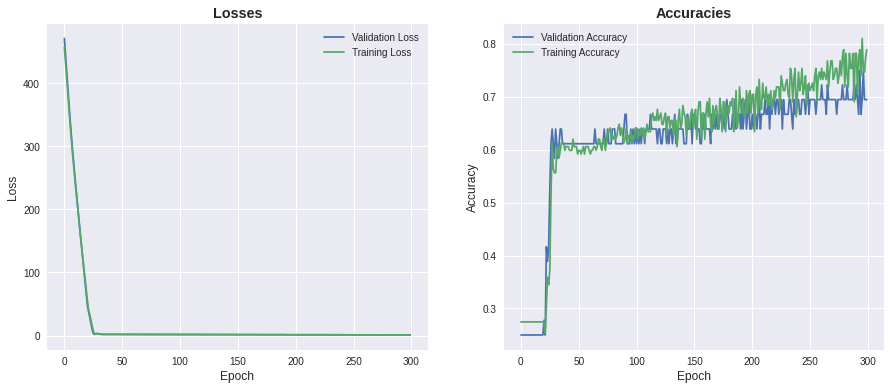

In [25]:
plt.style.use('seaborn')
f,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(history.history['val_loss'],label='Validation Loss')
ax[0].plot(history.history['loss'],label='Training Loss')
ax[0].set_title('Losses',weight='bold',size='x-large')
ax[0].set_xlabel('Epoch',size='large')
ax[0].set_ylabel('Loss',size='large')
ax[0].legend()

ax[1].plot(history.history['val_accuracy'],label='Validation Accuracy')
ax[1].plot(history.history['accuracy'],label='Training Accuracy')
ax[1].set_title('Accuracies',weight='bold',size='x-large')
ax[1].set_xlabel('Epoch',size='large')
ax[1].set_ylabel('Accuracy',size='large')
ax[1].legend()

plt.show()

# End Notes
There is a lot more that the `tf 2.0` offers you while building custom layers and models including **metrics**, **losses** and much more inside the layers. Please refer more at the official documentation. Hope you enjoyed reading. Good Luck with your journey.